# Recommendation System

In this project I will build a Recommendation System. Purpose of this system:

> Recommend posts to a user

> Recommend posts when given a post

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Lib

In [ ]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1MB 7.3MB/s 
     |████████████████████████████████| 1.2MB 36.9MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 358kB 41.4MB/s 
     |████████████████████████████████| 174kB 52.5MB/s 
     |████████████████████████████████| 645kB 51.0MB/s 
     |████████████████████████████████| 706kB 51.5MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import copy

import tensorflow as tf 
import tensorflow_hub as hub 
import tensorflow_datasets as tfds 

import official.nlp.bert.tokenization as tokenization
import glob
from tqdm import tqdm
import keras
from keras.layers import *

# Load Data

In [ ]:
posts_df = pd.read_csv('/content/drive/MyDrive/recomendation-system/posts.csv')
users_df = pd.read_csv('/content/drive/MyDrive/recomendation-system/users.csv')
views_df = pd.read_csv('/content/drive/MyDrive/recomendation-system/views.csv')

## Exploratory Data Analysis

### 1. Posts 

In [ ]:
posts_df.head()

,_id,title,category,post_type
0,5d62abaa65218653a132c956,hello there,Plant Biotechnology,blog
1,5d6d39567fa40e1417a4931c,Ml and AI,Artificial Intelligence|Machine Learning|Infor...,blog
2,5d7d23315720533e15c3b1ee,What is an Operating System ?,Operating Systems,blog
3,5d7d405e5720533e15c3b1f3,Lord Shiva,Drawings,artwork
4,5d80dfbc6c53455f896e600e,How Competition law evolved?,Competition Laws,blog


In [ ]:
posts_df.isnull().sum()

_id            0
title          0
category      28
 post_type     0
dtype: int64

In [ ]:
posts_df.category.value_counts()

Photography                                                                               81
Drawings                                                                                  47
Painting                                                                                  20
Visual Arts                                                                               10
Computer Technology|Computer Application|Information Technology                            7
                                                                                          ..
Programming languages                                                                      1
Psycholgy|Child Development                                                                1
Accounting|Partnership Accounting|Corporate Accounting|Accounting Theory And Practices     1
Biotechnology|Environmental Biotechnology                                                  1
Auditing|Cost Audit                                                   

> There are more than 231 categories. The category has most posts is `Photography` 

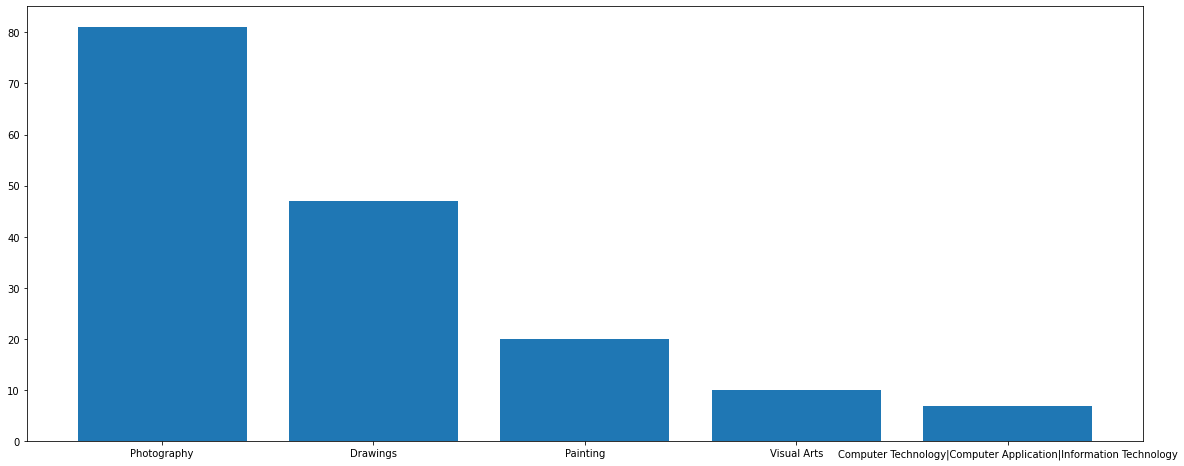

In [ ]:
import matplotlib.pyplot as plt
a = posts_df.category.value_counts()
fig = plt.figure(figsize=(20, 8))
cats = list(dict(a).keys())[:5]
posts = list(dict(a).values())[:5]
plt.bar(cats,posts)
plt.show()

### 2. Users 

In [ ]:
users_df.head()

,_id,name,gender,academics
0,5d60098a653a331687083238,Nivesh Singh Chauhan,male,undergraduate
1,5d610ae1653a331687083239,Gaurav Sharma,male,graduate
2,5d618359fc5fcf3bdd9a0910,Akshay Mishra,male,undergraduate
3,5d6d2bb87fa40e1417a49315,Saksham Mathur,male,undergraduate
4,5d7c994d5720533e15c3b1e9,Varun Chowhan,male,undergraduate


In [ ]:
male = users_df[users_df['gender']=='male']
male_gradutate = male[male['academics']=='graduate']
male_undergraduate = male[male['academics']=='undergraduate']

female = users_df[users_df['gender']=='female']
female_gradutate = male[male['academics']=='graduate']
female_undergraduate = male[male['academics']=='undergraduate']

In [ ]:
users_df

,_id,name,gender,academics
0,5d60098a653a331687083238,Nivesh Singh Chauhan,male,undergraduate
1,5d610ae1653a331687083239,Gaurav Sharma,male,graduate
2,5d618359fc5fcf3bdd9a0910,Akshay Mishra,male,undergraduate
3,5d6d2bb87fa40e1417a49315,Saksham Mathur,male,undergraduate
4,5d7c994d5720533e15c3b1e9,Varun Chowhan,male,undergraduate
...,...,...,...,...
113,5ed35aa376027d35905cca67,Steve,male,graduate
114,5ed3737976027d35905ccaa2,Himanshu Singh,male,undergraduate
115,5ed3748576027d35905ccaab,Parth Vijay,male,undergraduate
116,5ed3cbcbbd514d602c1530a7,Abhishek Mishra,male,undergraduate


In [ ]:
views_df.head()

,user_id,post_id,timestamp
0,5df49b32cc709107827fb3c7,5ec821ddec493f4a2655889e,2020-06-01T10:46:45.131Z
1,5ed3748576027d35905ccaab,5ed4cbadbd514d602c1531a6,2020-06-01T09:39:20.021Z
2,5ed0defa76027d35905cc2de,5eac305f10426255a7aa9dd3,2020-06-01T08:12:42.682Z
3,5ed0defa76027d35905cc2de,5ed1ff0276027d35905cc60d,2020-06-01T08:10:23.880Z
4,5ed0defa76027d35905cc2de,5ed3820f76027d35905ccac8,2020-06-01T08:08:54.124Z


# Build Recommend System


## Collaborative Filtering


### 1. Memory based collaborative approaches

> In this aproach, I create the interaction matrix which the value of line i, column j is `the number of views` of the i-th user to the j-th post

> Then a user will be represented by a vector has `n_posts dimension`, value of each element of vector will indicate that the user has view that post or hasn't. 

> To recommend posts to a user, I find the other user (called B) most similar to user need to be recommended (called A). Then recommended posts for A will be the posts that B has viewed and A hasn't viewed

> To calculate similarity, I use `cosine similarity`

> In contrast, to recommend posts to a given post, I find k posts most similar to the given post. Each post will be represented by a vector has `n_user dimension`,  


#### Implement

> First step in memory based collaborative approaches is build a user-item iteraction matrix.

In [ ]:
def kthmax(k, list):
  if (k == 1):
      return max(list)
  else:
      m = max(list)
      return(kthmax(k-1, [x for x in list if x != m]))

class CF(): # Collaborative Filtering
  def __init__(self, users_df, items_df, views_df ,dist_func = cosine_similarity ,type_CF=1):
    '''
    Params:
      data: interaction matrix
      dist_func: similarity function
      type_CF: type of collaborative filtering. 1 is user-user, 0 is item-item
    '''
    self.users_df = users_df
    self.items_df = items_df
    self.views_df = views_df
    self.create_interaction_matrix()
    
    self.n_users = self.data.shape[0]
    self.n_items = self.data.shape[1]    
    
    self.type_CF = type_CF
    if type_CF ==0:
      self.data = np.transpose(self.data)
    self.dist_func = dist_func

  def create_interaction_matrix(self):
    n_users = self.users_df.shape[0]
    n_items = self.items_df.shape[0]
    
    # for fast retrieval create a dict of number of views of each user_post 
    user_view_dict = {}
    for i, view in self.views_df.iterrows():
      key = view['user_id'] + ':' + view['post_id']
      if key not in user_view_dict.keys():
          user_view_dict[key] = 1
      else:
          user_view_dict[key] += 1

    # create a binary matrix
    interaction_matrix = np.zeros(shape=(n_users,n_items),dtype=np.int32)

    for i, user in self.users_df.iterrows():
      for j, item in self.items_df.iterrows():
        query_key = user['_id'] + ':' + item['_id']
        if query_key in user_view_dict.keys():
          interaction_matrix[i][j] = user_view_dict[key]        
    self.data = interaction_matrix

  def add(self, new_data): # when there is new interaction of user
    self.data = np.concatenate((self.data, new_data), axis=0)

  def similarity(self): 
    self.S = self.dist_func(self.data, self.data)
  
  def fit(self):
    self.similarity()

  def recommend(self, u): # u is _id of post or user
    """
    Determine items should be recommended for user u (typeCF=1)
    or users who might have interest on item u (typeCF=0)
    Suppose we are considering items which have not been viewed would
    be recommended.
    """
    # get similarity between u and others. 
    # if user-user: similarity is a matrix: (n_user,n_user): each line is similarity score of n_user to n_user include itself.
    # get the index of most similar user then get user vector representation: n_items dimension -> recommend the item which haven't seen by user. 
    # incase there is no item to recommend then get the index of the second largest user,... 

    self.fit()
    if self.type_CF == 0: # recommend posts to a given post
      idx = self.items_df[self.items_df['_id']==u['_id']].index
      idx = idx[0]
      s_vec = self.S[idx]
      # find index of post:
      kth = 10
      #k_largest_indices = self.data[np.argsort(s_vec,)[-(kth+1):]] # k most largest similarity
      idx = np.argpartition(s_vec, -kth)[-kth:]
      indices = idx[np.argsort((-s_vec)[idx])]
      indices = indices[1:]
      
      # cond = self.posts_df['_id'].isin(self.user_posts['_id'])  
      # remain_posts = self.posts_df[cond==False]
      # index_values = np.array(posts_df.index)
      # data = bert_input(remain_posts,tokenizer)
      # pred = self.model.predict(data)
      return self.items_df.loc[indices]

    # get the most similarity
    idx = self.users_df[self.users_df['_id']==u['_id']].index
    idx = idx[0]
    s_vec = self.S[idx]
    most_user_idx = np.argpartition(s_vec, -2)[-2:]
    
    indices = most_user_idx[np.argsort((-s_vec)[most_user_idx])]
    indices = indices[1:]
    posts_of_similar_user = self.data[indices[0]] 
    posts_of_user = self.data[idx]
    re_posts = []
    for i,value in enumerate(posts_of_similar_user):
      if value > 0 and posts_of_user[i]==0:
        re_posts.append(i)
    re_posts = np.array(re_posts)
    # for i in range(len(s_vec-1)):
    #   res = []
    #   kth = 1
    #   sim_u = self.data[np.argsort(s_vec,)[-(kth+1):][0]]
    #   for i,value in enumerate(sim_u):
    #     if value >= 1 and self.data[u][i] == 0:
    #       res.append(i)
    #   if len(res) > 0:
    #     break
    #   else:
    #     kth += 1                         
    return self.items_df.loc[re_posts]    

#### Run

> 1. Run collaborative filtering to recommend posts to a given post

In [ ]:
cf = CF(users_df,posts_df,views_df,type_CF=0)
print('----Query post----')
print(posts_df.loc[2])
res = cf.recommend(dict(posts_df.loc[2]))
print('\n----Top 10 results----')
res

----Query post----
_id                5d7d23315720533e15c3b1ee
title         What is an Operating System ?
category                  Operating Systems
 post_type                             blog
Name: 2, dtype: object

----Top 10 results----


,_id,title,category,post_type
64,5e3e9cc0eab55d319938a79b,C#(.NET),Computer Technology|Programming languages,blog
45,5e36746a8d344822fed4d147,ROMAN REIGNS,Drawings,artwork
79,5e431bf9eab55d319938a86a,Computer Graphics,Graphics|Computer Creation,blog
105,5e502673d15de17a8cf1b946,Data Transmission Modes,Computer Technology|Computer Application|Opera...,blog
104,5e5023f1d15de17a8cf1b939,Applications of mobile computing,Computer Technology|Computer Application,blog
103,5e50207cd15de17a8cf1b92c,Mobile Computing Technology,Computer Technology|Mobile Applications,blog
102,5e501d55d15de17a8cf1b91f,DATA AND MESSAGE SECURITY,Computer Technology|Computer Application,blog
77,5e41b98eeab55d319938a82d,PHP Variables,Computer Technology|Design and Analysis of Alg...,blog
50,5e372ee2eab55d319938a6ed,SEO (Search Engine Optimization),Computer Technology|Computation,blog


> 2. Run collaborative filtering to recommend posts to a user

In [ ]:
cf = CF(users_df,posts_df,views_df,type_CF=1)
print('----Query post----')
print(users_df.loc[1])
res = cf.recommend(dict(users_df.loc[1]))
print('\n----Results----')
res

----Query post----
_id          5d610ae1653a331687083239
name                    Gaurav Sharma
gender                           male
academics                    graduate
Name: 1, dtype: object

----Results----


,_id,title,category,post_type
0,5d62abaa65218653a132c956,hello there,Plant Biotechnology,blog
1,5d6d39567fa40e1417a4931c,Ml and AI,Artificial Intelligence|Machine Learning|Infor...,blog
20,5dbc631f99cbb90e4339c7fd,Calligraphy,Drawings|Calligraphy,artwork
21,5dc065ca24b883670268772f,Colours of pushkar.,Photography,artwork
24,5ddeb6e80eb5e25a8a07f065,Library Managment System: Software Requirement...,NaN,project
...,...,...,...,...
459,5ecfffb976027d35905cc0e9,Xbox Series X To Launch With 'Thousands' of Games,Mixed Media,artwork
461,5ed09ad076027d35905cc15f,Understanding Cloud Computing(AWS),Computer Technology|Cloud Computing,blog
462,5ed0e20776027d35905cc2fe,Here are 7 of my favourite books that I've rea...,Literature|Stories|Fictions|Movements in Liter...,blog
470,5ed1ff0276027d35905cc60d,AWS services and how to launch OS on AWS Cloud,Computer Technology|Cloud Computing,blog


In [ ]:
posts_id = views_df[views_df['user_id'] == users_df['_id'][1]][['post_id']]
viewed_posts = posts_df[posts_df._id.apply(lambda x: x in posts_id.values)]
viewed_posts

,_id,title,category,post_type
4,5d80dfbc6c53455f896e600e,How Competition law evolved?,Competition Laws,blog
18,5db2b91a99cbb90e4339c749,CLASSIFYING FORMS OF CARTELS,Competition Laws,blog
37,5e2d36ebc85ab714a7da66d1,CONTOURING CLAY,Sculptures|Artistic design,artwork
38,5e2d3fbfc85ab714a7da66d5,Multipurpose Jewel,Fashion Design|Ceramics|Artistic design,artwork
39,5e2d447dc85ab714a7da66d7,Traditional and Modern Sports,Craft|Artistic design,artwork
...,...,...,...,...
449,5ecce8a5eaff6b0c3a58a5e9,The Waves Have Stood Still,Photography,artwork
450,5ecd5d417023451e662235c5,"Machine Learning”&“Operations"" (MlOps)",Computer Technology|Machine Learning,blog
451,5ecd6ba47023451e66223604,Be yourself !!,Photography,artwork
463,5ed0e31a76027d35905cc302,Designing Cmos circuit from Boolean expression...,NaN,project


> Compare what `Gaurav Sharma` viewed in the past and what we recommend him to read

> Statistic by `post_type`:

In [ ]:
print('--Posts he read in the past--')
print(viewed_posts[' post_type'].value_counts())
print('\n--Posts we recommend--')
print(recommended_posts[' post_type'].value_counts())

--Posts he read in the past--
artwork    77
blog       37
skill      13
project     5
Name:  post_type, dtype: int64

--Posts we recommend--
artwork    82
blog       53
skill       8
project     5
Name:  post_type, dtype: int64


> Quite reasonable: `artwork` and `blog` posts are most recommended

> Statistic by category:

In [ ]:
print('--Posts he read in the past--')
print(viewed_posts['category'].value_counts())
print('\n--Posts we recommend--')
print(recommended_posts['category'].value_counts())

--Posts he read in the past--
Photography                                           25
Drawings                                              14
Visual Arts                                            9
Painting                                               6
Mass Media|Indian Government                           3
                                                      ..
Social Work|NGO                                        1
Psycholgy|Child Development                            1
Zoology|Environmental Biology                          1
Mixed Media                                            1
Legal Studies|Company Law|Legal System|Banking Law     1
Name: category, Length: 70, dtype: int64

--Posts we recommend--
Photography                                                                                                      32
Drawings                                                                                                         16
Painting                                      

### Markdown

> There is no filter in the results (priority), you can see so many candidates (posts) after filtering. 

> This collaborative filter approach has a weekness called `cold start`. When there is a new user there is no pass interaction of this user to calculate similarity. 

> Moreover, this approach does not take advantage of information of the posts or the user to give recommendation. A user has tendency of view posts related to his major/interested field which can be shown through the frequency of post categories he has read.  


## Content-based recommender

In [ ]:
# Given a user recommend posts
# Given a post recomend posts

> Create a user embedding model based on user information and posts have read by user in the past. 

In [ ]:
from keras.utils import to_categorical
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True,name='bert_layer')
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def bert_input(user_posts, tokenizer, max_len=55):
    all_tokens = []
    all_masks = []
    all_segments = []

    for i,row in user_posts.iterrows():
      title = row['title']
      if type(title) != str:
        title = ''
      title = tokenizer.tokenize(title)
      category = row['category']
      if type(category) != str:
        category = ''
      category = tokenizer.tokenize(category)
      post_type = row[' post_type']
      if type(post_type) != str:
         post_type = ''
      post_type = tokenizer.tokenize(post_type)

      input_sequence = ["[CLS]"] + title +  category + post_type + ["[SEP]"]
      pad_len = max_len - len(input_sequence)
      
      tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0]*pad_len
      pad_masks = [1]*len(input_sequence)+[0]*pad_len
      segment_ids = [0]*max_len  # [1]*(len(category)+len(post_type) +1) 
      
      all_tokens.append(tokens)
      all_masks.append(pad_masks)
      all_segments.append(segment_ids)
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

class model_encoder():
  def get_history_posts(self):
    posts_id = self.views_df[self.views_df['user_id']==self.user_id][['post_id']]
    posts = self.posts_df._id.apply(lambda x: x in posts_id.values)
    self.user_posts =  posts_df[posts]
  def __init__(self, views_df, posts_df, user_id, max_len=55):
    self.user_id = user_id
    self.posts_df = posts_df
    self.views_df = views_df
    self.get_history_posts()

    module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
    bert_layer = hub.KerasLayer(module_url, trainable=True,name='bert_layer')

    input_word_ids = tf.keras.Input(shape=(max_len,),dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,),dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask,segment_ids])
    clf_output = sequence_output[:,0,:]
    cls_layer = Dense(6,activation='softmax')(clf_output)

    self.model = tf.keras.models.Model(inputs=[input_word_ids,input_mask,segment_ids], outputs=cls_layer)

  def get_label(self):
    post_categories = {}
    
    for value in self.user_posts.category.values:
      if type(value) is str:
        arr = value.split('|')
        for i in arr:
          if i not in post_categories.keys():
            post_categories[i] = 1
          else:
            post_categories[i] += 1

    most_intersted_categoris = [x[0] for x in post_categories.items() if x[1] == np.quantile(list(post_categories.values()), 1)]
    high_intersted_categoris = [x[0] for x in post_categories.items() if x[1] < np.quantile(list(post_categories.values()), 1) and x[1] >= np.quantile(list(post_categories.values()), 0.97)]
    medium_interested_categories = [x[0] for x in post_categories.items() if x[1] < np.quantile(list(post_categories.values()), 0.97) and x[1] >= np.quantile(list(post_categories.values()),0.75)]
    low_interested_categories = [x[0] for x in post_categories.items() if x[1] < np.quantile(list(post_categories.values()), 0.75) and x[1] > np.quantile(list(post_categories.values()),0.5)]
    lowest_interested_categories =  [x[0] for x in post_categories.items() if x[1] <= np.quantile(list(post_categories.values()), 0.5)]

    def label_post(x):
      if type(x) is str:
        arr = x.split('|')
        for value in arr:
          if value in most_intersted_categoris:
            return 0
        for value in arr:
          if value in high_intersted_categoris:
            return 1
        for value in arr:
          if value in medium_interested_categories:
            return 2
        for value in arr:
          if value in low_interested_categories:
            return 3
        for value in arr:
          if value in lowest_interested_categories:
            return 4
      return -1
    self.user_posts['label'] = self.user_posts.category.apply(lambda x: label_post(x))
    train_onehot_lbl = to_categorical(self.user_posts['label'].values,num_classes=6)
    return train_onehot_lbl

  def fit(self):
    self.get_history_posts()
    data = bert_input(self.user_posts, tokenizer)
    label = self.get_label()
    self.model .compile(optimizer = keras.optimizers.Adam(learning_rate=0.00001) , loss='categorical_crossentropy', metrics=['accuracy'])
    self.model.fit(x = data, y = label, batch_size=2, epochs=10, verbose=1)
    return self.model

  def recommend(self):
    self.user_posts.shape
    cond = self.posts_df['_id'].isin(self.user_posts['_id'])  
    remain_posts = self.posts_df[cond==False]
    index_values = np.array(posts_df.index)
    data = bert_input(remain_posts,tokenizer)
    pred = self.model.predict(data)

    res = []
    for i,row in enumerate(pred):
      max_prob = np.argmax(row)
      if max_prob == 0:
        res.append((i,row[max_prob]))
    # res: (i,j) index, probability 
    res = np.array(res)    
    topk = np.argsort(res[:,1],)[-10:] # topk largest prob
    topk = topk[::-1].astype('int32')
    return posts_df.loc[index_values[res[topk,0].astype('int32')]]


  def get_embedding(self,input):
    return self.model.predict([input])



> To tunning my embedding model, I need to lable the viewed post base on frequency category of viewed post read by user

In [ ]:
model = model_encoder(views_df=views_df, posts_df=posts_df, user_id = users_df['_id'][1])
model.fit()
res = model.recommend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/10
66/66 [==============================] - 23s 123ms/step - loss: 1.4678 - accuracy: 0.3828
Epoch 2/10
66/66 [==============================] - 8s 121ms/step - loss: 0.6492 - accuracy: 0.7741
Epoch 3/10
66/66 [==============================] - 8s 121ms/step - loss: 0.3956 - accuracy: 0.8334
Epoch 4/10
66/66 [==============================] - 8s 122ms/step - loss: 0.2247 - accuracy: 0.9535
Epoch 5/10
66/66 [==============================] - 8s 121ms/step - loss: 0.0748 - accuracy: 0.9985
Epoch 6/10
66/66 [==============================] - 8s 122ms/step - loss: 0.0561 - accuracy: 0.9885
Epoch 7/10
66/66 [==============================] - 8s 122ms/step - loss: 0.1086 - accuracy: 0.9583
Epoch 8/10
66/66 [==============================] - 8s 121ms/step - loss: 0.0163 - accuracy: 1.0000
Epoch 9/10
66/66 [==============================] - 8s 121ms/step - loss: 0.0306 - accuracy: 1.0000
Epoch 10/10
66/66 [==============================] - 8s 122ms/step - loss: 0.0084 - accuracy: 1.000

In [ ]:
res

,_id,title,category,post_type
299,5e979490a3258347b42f2b13,Vintage (JAISALMER IS A REAL BEAUTY AND SO IS ...,Photography|Conceptual,artwork
242,5e940dd0a3258347b42f27f1,freeze,Photography,artwork
196,5e81c101a3258347b42f22a3,Corona's Checklist,Visual Arts,artwork
201,5e81c29ea3258347b42f2303,Social Distancing,Visual Arts,artwork
204,5e82390ea3258347b42f2369,Oliveres mediterrànies,Geography|Physical Geography,blog
295,5e9754efa3258347b42f2ae8,No one's worth hate🧡,Drawings,artwork
258,5e948ce6a3258347b42f28aa,Hermit,Photography,artwork
291,5e966ad3a3258347b42f2aaf,8 Best Machine Learning Courses for 2020,Computer Technology|Cloud Computing|Artificial...,blog
205,5e8307ada3258347b42f23ec,Aesthetic,Photography,artwork
260,5e948db6a3258347b42f28b2,peace,Photography,artwork


##  Futher work


> In this attemp, I will use Recurrent Neural Network for predict next item to be viewed. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
class RNN_based_recommender():
  def __init__(self,views_df, posts_df, users_df):
    self.views_df = views_df
    self.posts_df = posts_df 
    self.users_df = users_df

  def get_history_views():
    posts_id = self.views_df[self.views_df['user_id']==self.user_id][['post_id']]
    posts = self.posts_df._id.apply(lambda x: x in posts_id.values)
    self.user_posts =  posts_df[posts]
  
    
  def create_random_list(list_size, population):
    sample = [] 
    count = 0 
    while count < list_size: 
      index = np.random.randint(0, len(population), size=1) 
      if population[index[0]] != 0: 
        sample.append(index[0]) 
        population[index[0]] = 0 
        count += 1
    return sample, population

  def generator(data, labels, pop, count, max_count, batch_size=12):
    while 1:
      n = batch_size
      if count == max_count-1:
        n = len(data) - (max_count-1)*batch_size
      indices, pop = create_random_list(n,pop)

      if count == max_count - 1:
        pop = []
        for i in range(0, len(data))
          pop.append(i+1)
        count = -1

      np.random.shuffle(indices)
      samples = data[indices]
      target = labels[indices]
      count += 1
      yield [samples, target]

  def create_model(batch_size):
    self.batch_size = batch_size
    self.max_count = np.ceil(self.user_posts.shape[0]/batch_size)

    model = keras.models.Sequential()
    model.add(LSTM(120, input_shape=(994,), return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(120, return_sequences=False))
    



  def create_training_data():
    tfidf = TfidfVectorizer(stop_words='english')
    # replace NaN with an empty string
    self.user_posts = self.user_posts.fillna('')
    corpus = np.concatenate((np.concatenate((self.user_posts['title'].values, self.user_posts['category'].values)),  self.user_posts[' post_type'].values))
    tfidf.fit(corpus) 
    
    training_data = []
    for i, row in self.user_posts.iterrows():
      str_ = row['title'] + ' ' + row['category'] + ' ' + row[' type_post']
      tfidf_embedding = tfidf.transform(str_)
      training_data.append(tfidf_embedding)
    training_data = np.array(training_data)
    self.training_data = training_data
    
  def recommend(user_id):
    self.user_id = user_id
    self.get_history_views()


    

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
posts_df = posts_df.fillna('')
corpus = np.concatenate((np.concatenate((posts_df['title'].values, posts_df['category'].values)), posts_df[' post_type'].values))
tfidf.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
vec= tfidf.transform(['Photography']).toarray()

In [ ]:
vec.shape

(1, 994)

In [ ]:
posts_df[['title', 'category',' post_type']]

,title,category,post_type
0,hello there,Plant Biotechnology,blog
1,Ml and AI,Artificial Intelligence|Machine Learning|Infor...,blog
2,What is an Operating System ?,Operating Systems,blog
3,Lord Shiva,Drawings,artwork
4,How Competition law evolved?,Competition Laws,blog
...,...,...,...
488,CI/CD using GitHub Actions,Computer Technology|Information Technology,blog
489,Configure Docker with Django; PostgreSQL; Pg-a...,Computer Technology|Computer Application|Infor...,blog
490,Recommendation Engine,NaN,project
491,Face Recognition using Transfer Learning.,Science; Technology,skill
